In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
cd ..

/home/pierreo


In [37]:
# test the GP cross validation
from problems import get_synthetic_problem
import torch
from search.trust_region import (
    restart,
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from search.utils import eigendecompose_laplacian
from search.models import initialize_model
from scipy.stats import spearmanr
from tqdm._tqdm import tqdm


Experiment to carry out:
- Sample graph
- Take eigendecomposition
- Take a eigenvalue
- Sample nodes
- Reconstruct signals and compare real one with different modes

In [45]:
n = 400
base_problem = get_synthetic_problem(
    "test_function", 
    n=n, 
    seed=2,
    problem_kwargs={
        "log": False, 
        "random_graph_type": "grid",
        "m": 1,
        "n": n,
        "test_function": "sphere"
        }
    )

X_train = torch.empty(0,1)
Y_train = torch.empty(0,1)
base_model, base_mll, based_cached_eigenbasis = initialize_model(
                train_X=X_train,
                train_Y=Y_train,
                context_graph=base_problem.context_graph,
                covar_type="diffusion",
                covar_kwargs = {
                    "order": 1,
                     },
                fit_model=False,
                ard=True,
                use_fixed_noise=False,
                use_saas_map=False
                )

In [61]:
def compute_test_result(base_problem, base_model, prop_data=0.5, mc_samples=5, n_eigenvalue=10):
    r = torch.arange(1,len(base_problem.context_graph), len(base_problem.context_graph) // n_eigenvalue)
    t = torch.zeros(mc_samples, 2, r.shape[0])
    for j_index, j in tqdm(enumerate(r)):
        for i in range(mc_samples):
            all_X = torch.arange(len(base_problem.context_graph)).to(torch.float)
            all_Y = base_model.covar_module.base_kernel.eigenbasis[:,j].detach().clone()
            from botorch.utils.transforms import standardize
            n_init = len(all_X)
            X = all_X.reshape(-1, 1).detach().clone()

            # Y = base_problem(X.reshape(-1, 1))
            Y = all_Y.reshape(-1, 1).to(dtype=torch.float).detach().clone()
            Y = standardize(Y)

            best_loc = Y.argmax().item()
            X_best = X[best_loc]

            n_train = int(n_init * prop_data)
            ntrain_indices = np.random.choice(n_init, n_train, replace=False)
            ntest_indices = np.array([i for i in range(n_init) if i not in ntrain_indices])
            X_train, Y_train = X[ntrain_indices, ...], Y[ntrain_indices]
            X_test, Y_test = X[ntest_indices, ...], Y[ntest_indices, ...]
            criterion = torch.nn.MSELoss()

            order = 5
            model_poly, mll_poly, cached_eigenbasis_poly = initialize_model(
                        train_X=X_train,
                        train_Y=Y_train,
                        context_graph=base_problem.context_graph,
                        covar_type="polynomial",
                        covar_kwargs = {
                            "order": order,
                            },
                        fit_model=True,
                        ard=True,
                        use_fixed_noise=False,
                        optim_kwargs = {
                            "train_iters": 500,
                            "lr": 0.1
                        },
                        use_saas_map=False
                        )
            
            model_diff, mll_diff, cached_eigenbasis_diff = initialize_model(
                        train_X=X_train,
                        train_Y=Y_train,
                        context_graph=base_problem.context_graph,
                        covar_type="polynomial",
                        covar_kwargs = {
                            "order": len(base_problem.context_graph.nodes),
                            },
                        fit_model=True,
                        ard=True,
                        use_fixed_noise=False,
                        optim_kwargs = {
                            "train_iters": 500,
                            "lr": 0.1
                        },
                        use_saas_map=False
                        )
            
            model_poly.eval()
            with torch.no_grad():
                # predict on train input
                Y_test_pred = model_poly.posterior(X_test).mean
                error = torch.sqrt(criterion(Y_test_pred, Y_test))
                #mll_poly(Y_test_pred, Y_test)
                t[i, 0, j_index] = error

            model_diff.eval()
            with torch.no_grad():
                # predict on train input
                Y_test_pred = model_diff.posterior(X_test).mean
                error = torch.sqrt(criterion(Y_test_pred, Y_test))
                t[i, 1, j_index] = error
    return t
        

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/home/pierreo/miniconda3/envs/graph/lib/python3.10/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
0it [00:00, ?it/s]/home/pierreo/miniconda3/envs/graph/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
10it [05:12, 31.27s/it]


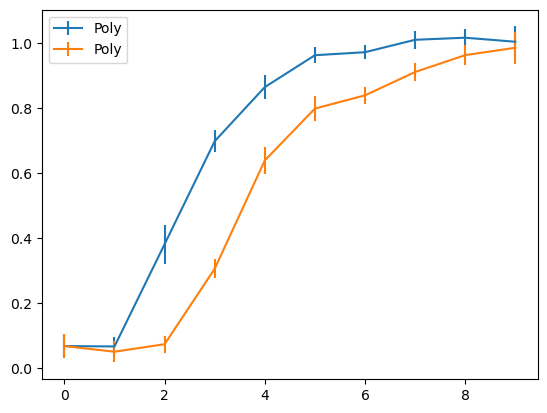

In [82]:
n = 400
base_problem = get_synthetic_problem(
    "test_function", 
    n=n, 
    seed=2,
    problem_kwargs={
        "log": False, 
        "random_graph_type": "grid",
        "m": 1,
        "n": n,
        "test_function": "sphere"
        }
    )

X_train = torch.empty(0,1)
Y_train = torch.empty(0,1)
base_model, base_mll, based_cached_eigenbasis = initialize_model(
                train_X=X_train,
                train_Y=Y_train,
                context_graph=base_problem.context_graph,
                covar_type="diffusion",
                covar_kwargs = {
                    "order": 1,
                     },
                fit_model=False,
                ard=True,
                use_fixed_noise=False,
                use_saas_map=False
                )

result = compute_test_result(base_problem, base_model, mc_samples=10, prop_data=0.5, n_eigenvalue=10)
result_mean_0, result_std_0 = result.mean(dim=0)[0], result.std(dim=0)[0]  
result_mean_1, result_std_1 = result.mean(dim=0)[1], result.std(dim=0)[1]  
plt.errorbar(x = range(result_mean_0.shape[0]), y = result_mean_0, yerr= result_std_0, label="Poly")
plt.errorbar(x = range(result_mean_1.shape[0]), y = result_mean_1, yerr= result_std_1, label="Poly")
plt.legend()

In [83]:
n = 400
base_problem = get_synthetic_problem(
    "test_function", 
    n=n, 
    seed=2,
    problem_kwargs={
        "log": False, 
        "random_graph_type": "ba",
        "m": 2,
        "n": n,
        "test_function": "sphere"
        }
    )

X_train = torch.empty(0,1)
Y_train = torch.empty(0,1)
base_model, base_mll, based_cached_eigenbasis = initialize_model(
                train_X=X_train,
                train_Y=Y_train,
                context_graph=base_problem.context_graph,
                covar_type="diffusion",
                covar_kwargs = {
                    "order": 1,
                     },
                fit_model=False,
                ard=True,
                use_fixed_noise=False,
                use_saas_map=False
                )

result = compute_test_result(base_problem, base_model, mc_samples=10, prop_data=0.5, n_eigenvalue=10)
result_mean_0, result_std_0 = result.mean(dim=0)[0], result.std(dim=0)[0]  
result_mean_1, result_std_1 = result.mean(dim=0)[1], result.std(dim=0)[1]  
plt.errorbar(x = range(result_mean_0.shape[0]), y = result_mean_0, yerr= result_std_0, label="Poly")
plt.errorbar(x = range(result_mean_1.shape[0]), y = result_mean_1, yerr= result_std_1, label="Poly")
plt.legend()

2it [01:02, 31.27s/it]

In [ ]:
n = 400
base_problem = get_synthetic_problem(
    "test_function", 
    n=n, 
    seed=2,
    problem_kwargs={
        "log": False, 
        "random_graph_type": "ws",
        "m": 2,
        "p": 0.2,
        "k": 4,
        "test_function": "sphere"
        }
    )

X_train = torch.empty(0,1)
Y_train = torch.empty(0,1)
base_model, base_mll, based_cached_eigenbasis = initialize_model(
                train_X=X_train,
                train_Y=Y_train,
                context_graph=base_problem.context_graph,
                covar_type="diffusion",
                covar_kwargs = {
                    "order": 1,
                     },
                fit_model=False,
                ard=True,
                use_fixed_noise=False,
                use_saas_map=False
                )

result = compute_test_result(base_problem, base_model, mc_samples=10, prop_data=0.5, n_eigenvalue=10)
result_mean_0, result_std_0 = result.mean(dim=0)[0], result.std(dim=0)[0]  
result_mean_1, result_std_1 = result.mean(dim=0)[1], result.std(dim=0)[1]  
plt.errorbar(x = range(result_mean_0.shape[0]), y = result_mean_0, yerr= result_std_0, label="Poly")
plt.errorbar(x = range(result_mean_1.shape[0]), y = result_mean_1, yerr= result_std_1, label="Poly")
plt.legend()